In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

np.random.seed(7)



In [ ]:
#Carrega Dados
df=arquivo = pd.read_csv('./solicitacoescredito.csv')

#Somente linhas com Valor Aprovado
df=df.loc[df['valorAprovado']>0]

#Conslolida os valores aprovados em uma coluna
df['dataAprovado'] = np.where(df['status'] == 'AprovadoAnalista', df['dataAprovadoNivelAnalista'], df['dataAprovadoEmComite'])

#Somente precisamos de data e valor
df=df[['dataAprovado','valorAprovado']]

#Coloca a Data como uma tipo data
df['dataAprovado']=pd.to_datetime(pd.to_datetime(df['dataAprovado'],errors='coerce').dt.date)
#Consolida os valores aprovados por data
df=df.groupby('dataAprovado',as_index = False)['valorAprovado'].sum()

#Ordena crescente pela data
df=df.sort('dataAprovado')



Epoch 1/10
169/169 [==============================] - 23s 120ms/step - loss: 0.0107
Epoch 2/10
169/169 [==============================] - 20s 116ms/step - loss: 0.0103
Epoch 3/10
169/169 [==============================] - 19s 111ms/step - loss: 0.0106
Epoch 4/10
169/169 [==============================] - 19s 110ms/step - loss: 0.0098
Epoch 5/10
169/169 [==============================] - 18s 109ms/step - loss: 0.0101
Epoch 6/10
169/169 [==============================] - 18s 107ms/step - loss: 0.0103
Epoch 7/10
169/169 [==============================] - 19s 110ms/step - loss: 0.0091
Epoch 8/10
169/169 [==============================] - 18s 109ms/step - loss: 0.0097
Epoch 9/10
169/169 [==============================] - 19s 110ms/step - loss: 0.0100
Epoch 10/10
169/169 [==============================] - 18s 108ms/step - loss: 0.0104
Train Score: 2801145.66 RMSE
Test Score: 6264691.18 RMSE


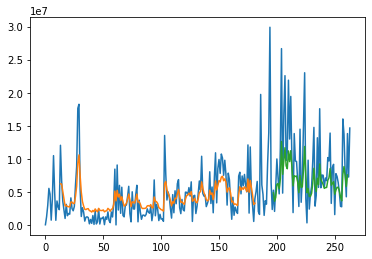

In [6]:


#Somente temos uma feature, precisamos de uma array na entrada

X = df.valorAprovado.values.reshape(-1, 1)
X = X.astype('float32')

#Normaliza o dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#scaler = StandardScaler()
X = scaler.fit_transform(X)

# split into train and test sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

# quantidade de atrasos
look_back = 14

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(512,return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(512))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

# PrediÃ§Ãµes
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Faz a transformaÃ§Ã£o inversa das prediÃ§Ãµes
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

# # Prepara o vetor para plotagem do conjunto das prediÃ§Ãµes
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

# Plota o dataset, as prediÃ§Ãµes sobre o conjunto de treinamento e teste
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()